# AI300 Capstone - Team 11

## Package Import

In [1]:
# for EDA
import numpy as np
import pandas as pd
import statistics

# for visualizations
import plotly.express as px 
import matplotlib.pyplot as plt
# import plotly.figure_factory as ff

# data ingest from db
from sqlalchemy import create_engine

# for ML
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.model_selection import KFold, GridSearchCV,StratifiedKFold, train_test_split
import shap
# from sklearn.model_selection import Kfold

# for pickles
import joblib

## Data Ingest from CSV

In [2]:
train_df = pd.read_csv("data/rawdata.csv") # data extracted from SQL DB and accessed from local machine
train_df.head(5)

,customer_id,status,churn_label,churn_category,churn_reason,account_id,customer_id.1,tenure_months,num_referrals,has_internet_service,...,senior_citizen,married,num_dependents,zip_code,area_id,zip_code.1,city,latitutde,longitude,population
0,0013-EXCHZ,Churned,Yes,Dissatisfaction,Network reliability,BFIN-DLMOA,0013-EXCHZ,3,3,Yes,...,Yes,Yes,0,93010,607,93010,Camarillo,34.227846,-119.079903,42853
1,0014-BMAQU,Stayed,No,NaN,NaN,AFEO-XOOCP,0014-BMAQU,63,8,Yes,...,No,Yes,0,94558,963,94558,Napa,38.489789,-122.270110,63947
2,0016-QLJIS,Stayed,No,NaN,NaN,DEMQ-MFXWC,0016-QLJIS,65,3,Yes,...,No,Yes,1,95681,1390,95681,Sheridan,38.984756,-121.345074,1219
3,0019-EFAEP,Stayed,No,NaN,NaN,AIPP-VTDXJ,0019-EFAEP,72,0,Yes,...,No,No,0,91942,303,91942,La Mesa,32.782501,-117.016110,24005
4,0019-GFNTW,Stayed,No,NaN,NaN,CJHA-SRKIB,0019-GFNTW,56,0,Yes,...,No,No,0,93441,716,93441,Los Olivos,34.704340,-120.026090,1317


## Impute and Filtering

In [3]:
train_df = train_df[train_df['status'] != 'Joined'] # drop recently joined users 
train_df = train_df[train_df['churn_label'].notnull()] # drop missing values

# impute any NaN with '' for cols with string dtype
for col in train_df.select_dtypes(include='object').columns.values:
    train_df[col] = train_df[col].fillna('')

train_df.head(5)

,customer_id,status,churn_label,churn_category,churn_reason,account_id,customer_id.1,tenure_months,num_referrals,has_internet_service,...,senior_citizen,married,num_dependents,zip_code,area_id,zip_code.1,city,latitutde,longitude,population
0,0013-EXCHZ,Churned,Yes,Dissatisfaction,Network reliability,BFIN-DLMOA,0013-EXCHZ,3,3,Yes,...,Yes,Yes,0,93010,607,93010,Camarillo,34.227846,-119.079903,42853
1,0014-BMAQU,Stayed,No,,,AFEO-XOOCP,0014-BMAQU,63,8,Yes,...,No,Yes,0,94558,963,94558,Napa,38.489789,-122.270110,63947
2,0016-QLJIS,Stayed,No,,,DEMQ-MFXWC,0016-QLJIS,65,3,Yes,...,No,Yes,1,95681,1390,95681,Sheridan,38.984756,-121.345074,1219
3,0019-EFAEP,Stayed,No,,,AIPP-VTDXJ,0019-EFAEP,72,0,Yes,...,No,No,0,91942,303,91942,La Mesa,32.782501,-117.016110,24005
4,0019-GFNTW,Stayed,No,,,CJHA-SRKIB,0019-GFNTW,56,0,Yes,...,No,No,0,93441,716,93441,Los Olivos,34.704340,-120.026090,1317


## EDA

In [4]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure_months,6537.0,34.632094,23.962097,1.000000,12.000000,32.000000,57.000000,72.000000
num_referrals,6537.0,2.031819,3.031187,0.000000,0.000000,0.000000,3.000000,11.000000
avg_long_distance_fee_monthly,6537.0,23.000407,15.470337,0.000000,9.260000,22.920000,36.440000,49.990000
total_long_distance_fee,6537.0,801.189875,855.146776,0.000000,108.160000,475.680000,1280.980000,3564.720000
avg_gb_download_monthly,6537.0,20.897659,20.423996,0.000000,4.000000,17.000000,27.000000,85.000000
total_monthly_fee,6537.0,66.148180,29.946916,18.250000,40.350000,72.450000,90.550000,118.750000
total_charges_quarter,6537.0,2439.689344,2267.891087,18.850000,551.300000,1567.000000,4016.200000,8684.800000
total_refunds,6537.0,2.097491,8.155182,0.000000,0.000000,0.000000,0.000000,49.790000
age,6537.0,46.740095,16.843125,19.000000,33.000000,46.000000,60.000000,80.000000
num_dependents,6537.0,0.478354,0.970431,0.000000,0.000000,0.000000,0.000000,9.000000


In [5]:
viz_df = train_df
fig = px.histogram(viz_df,
                   x='total_charges_quarter',
                   color='churn_label'
                  )
fig.show()

In [6]:
viz_df = train_df
fig = px.histogram(viz_df,
                   x='contract_type',
                   color='churn_label'
                  )
fig.show()

In [7]:
viz_df = train_df
fig = px.histogram(viz_df,
                   x='tenure_months',
                   color='churn_label'
                  )
fig.show()

In [11]:
cols_to_drop =['customer_id.1', # drop unwanted columns
               'account_id.1',
               'customer_id.2',
               'zip_code.1',
               'longitude',
               'latitutde',
               'status',
               'churn_category',
               'churn_reason',
               'customer_id',
               'account_id'
              ]

train_df.drop(labels=cols_to_drop,axis=1,inplace=True)
train_df.head(5)

,churn_label,tenure_months,num_referrals,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,...,total_refunds,gender,age,senior_citizen,married,num_dependents,zip_code,area_id,city,population
0,Yes,3,3,Yes,Fiber Optic,Yes,Yes,No,Yes,No,...,0.0,Female,75,Yes,Yes,0,93010,607,Camarillo,42853
1,No,63,8,Yes,Fiber Optic,No,Yes,Yes,Yes,Yes,...,0.0,Male,52,No,Yes,0,94558,963,Napa,63947
2,No,65,3,Yes,Cable,Yes,Yes,Yes,Yes,Yes,...,0.0,Female,43,No,Yes,1,95681,1390,Sheridan,1219
3,No,72,0,Yes,Fiber Optic,Yes,Yes,Yes,No,Yes,...,0.0,Female,32,No,No,0,91942,303,La Mesa,24005
4,No,56,0,Yes,DSL,Yes,No,No,Yes,Yes,...,0.0,Female,39,No,No,0,93441,716,Los Olivos,1317


## Model - CatBoost

In [12]:
cat_df = train_df
X = cat_df.drop(labels='churn_label',
                        axis=1) # drop target variable

y = LabelEncoder().fit_transform(cat_df['churn_label']) # binarize target feature
y = pd.Series(y)


cat_cols = X.select_dtypes('object').columns.values # creating var for categorical features
cat_cols = cat_cols.tolist()

**Catboost with Kfold**
<br> *Simple Catboost with Kfold as a pilot model*

In [14]:
N_ESTIMATORS = 100
RANDOM_STATE = 0

catboost = CatBoostClassifier(random_state=RANDOM_STATE,
                              depth = 5,
                            iterations=N_ESTIMATORS,
                            silent=True
                            )

def k_fold_validation(regressor, X, y):
    kf = KFold(n_splits=3)
    k_fold_auc = []

    for train_index, test_index in kf.split(X):

        # Extract the training and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit model
        model = regressor.fit(X_train, y_train,cat_features=cat_cols)
        y_pred = model.predict_proba(X_test)

        #Calculate AUC for the fold and append it
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
        k_fold_auc.append(auc(fpr,tpr).round(4))
        
    return 'Average AUC: ' + str({statistics.mean(k_fold_auc)})

k_fold_validation(catboost,X,y)

'Average AUC: {0.9446}'

**Catboost with GridSearch**<br>
*Given that Catboost has been quite performant, doing a search for more optimal params*

In [15]:
N_ESTIMATORS = 100
RANDOM_STATE = 0

catboost = CatBoostClassifier(random_state=RANDOM_STATE,
                            iterations=N_ESTIMATORS,
                            silent=True,
                            cat_features = cat_cols,
                            )


params_grid = {
          'learning_rate':[0.01,0.1,0.15],
          'max_depth': [3,4,5],
        }


grid = GridSearchCV(catboost,
                    params_grid,
                    scoring='f1',
                    refit = True,
                    cv=5
                   ) 
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.7820658479431386
{'learning_rate': 0.15, 'max_depth': 5}


## Feature Importance Evaluation

Features by Feature Importance
tenure_months            19.915328
contract_type            17.393318
num_dependents           15.230282
num_referrals            12.752890
internet_type             4.669105
age                       3.712594
total_charges_quarter     3.435251
total_monthly_fee         2.654165
city                      2.331991
zip_code                  1.948769
payment_method            1.886954
area_id                   1.601483
population                1.361385
stream_movie              1.204563
married                   1.122176
dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

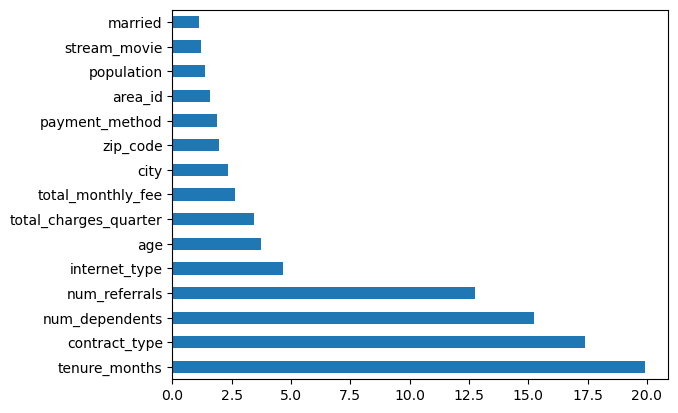

In [16]:
feat_importances = pd.Series(grid.best_estimator_.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_importances.nlargest(15).plot(kind='barh')
print('Features by Feature Importance')
print(feat_importances.nlargest(15))
plt.show

In [18]:
explainer = shap.Explainer(grid.best_estimator_)
shap_values = explainer(X)
# shap_values = explainer.shap_values(X)

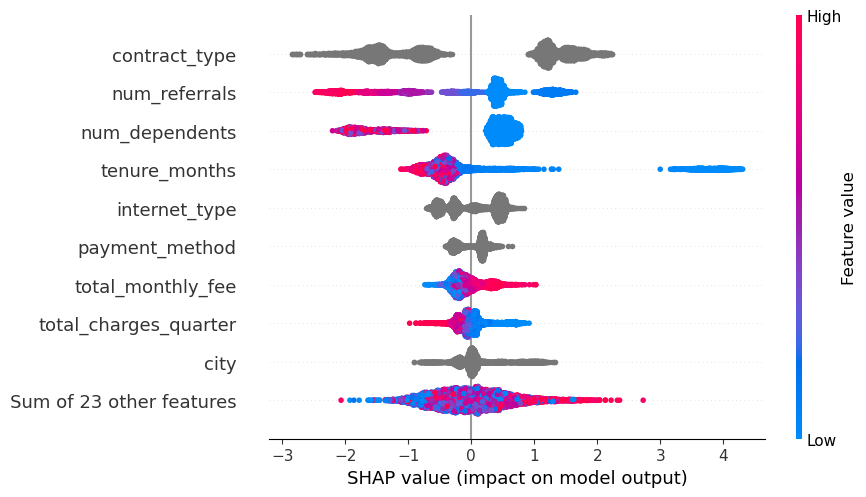

In [19]:
shap.plots.beeswarm(shap_values)

## Testing CatBoost with Top N Features by AUC <br>
*Given not all features are equal when it comes to predictive power, here I am determining the # of features required balance accurate prediction vs end-user ease of use. Here I use a simple Kfold validation and iterate through the features with the highest SHAP values*

In [24]:
cat_df = train_df

y = train_df['churn_label']
y = LabelEncoder().fit_transform(cat_df['churn_label']) # binarize target feature
y = pd.Series(y)

catboost = CatBoostClassifier(random_state=RANDOM_STATE,
                            depth = 5,
                            learning_rate = 0.15, # best params from GridsearchCV
                            iterations=N_ESTIMATORS,
                            silent=True,
                            )


def k_fold_validation(regressor, X, y):
    kf = KFold(n_splits=5)
    k_fold_auc = []

    for train_index, test_index in kf.split(X):

        # Extract the training and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit model
        model = regressor.fit(X_train, y_train,cat_features=cat_cols)
        y_pred = model.predict_proba(X_test)

        #Calculate AUC for the fold and append it
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
        k_fold_auc.append(auc(fpr,tpr).round(3))
    return (i,statistics.mean(k_fold_auc))


auc_n_feature = {}

for i in range(1,16):
    cols_to_keep = feat_importances.nlargest(i).index.values.tolist() # list of top N features based on SHAP values
    X = cat_df[cols_to_keep]

    cat_cols = X.select_dtypes('object').columns.values 
    cat_cols = cat_cols.tolist()

    auc_mean = k_fold_validation(catboost,X,y)
    auc_n_feature[i] = auc_mean

auc_n_feature

{1: (1, 0.7866000000000001),
 2: (2, 0.8586),
 3: (3, 0.8842),
 4: (4, 0.9134),
 5: (5, 0.9304),
 6: (6, 0.936),
 7: (7, 0.9352),
 8: (8, 0.937),
 9: (9, 0.943),
 10: (10, 0.9431999999999999),
 11: (11, 0.9438),
 12: (12, 0.9424),
 13: (13, 0.9434),
 14: (14, 0.9431999999999999),
 15: (15, 0.9436)}

In [25]:
auc_by_feature = pd.DataFrame.from_dict(auc_n_feature,orient='index',columns=['num_features','mean_AUC'])
auc_by_feature['mean_AUC'] = auc_by_feature['mean_AUC'].round(3)

fig = px.line(auc_by_feature,
             x='num_features',
             y='mean_AUC',
             text='mean_AUC',
             title='Mean AUC of model by Top N Features')

fig.update_traces(textposition='top center')

fig.show()


As the top 5 features is able to give us an AUC of 0.93 and the increase in AUC per additional feature decrease significantly after that, I opted to use the top 5 features for my webapp.

In [17]:
feat_importances.nlargest(5).index.values.tolist() # top 5 features to use in app

['tenure_months',
 'contract_type',
 'num_referrals',
 'num_dependents',
 'internet_type']

## Pickle Model <br>
*Refiting the model for pickling*


In [27]:
cols_to_keep = feat_importances.nlargest(5).index.values.tolist() # list of top 5 features based on Feat impt
X = cat_df[cols_to_keep]

cat_cols = X.select_dtypes('object').columns.values 
cat_cols = cat_cols.tolist()

catboost = CatBoostClassifier(random_state=RANDOM_STATE,
                            depth = 5,
                            iterations=N_ESTIMATORS,
                            learning_rate = 0.15,
                            silent=True,
                            cat_features = cat_cols
                            )

catboost.fit(X,y)

joblib.dump(catboost, 'model/catboost_model.pkl')

['model/catboost_model.pkl']

## Threshold (Youden's J) 
*To determine the threshold to use for determining churn users*

In [29]:
cols_to_keep = feat_importances.nlargest(5).index.values.tolist()
test_df = cat_df[cols_to_keep]

cat_cols = test_df.select_dtypes('object').columns.values 
cat_cols = cat_cols.tolist()

X_train, X_test, y_train, y_test = train_test_split(test_df, y, test_size=0.30, random_state=RANDOM_STATE) # Train test split

catboost = CatBoostClassifier(random_state=RANDOM_STATE,
                            depth = 5,
                            iterations=N_ESTIMATORS,
                            learning_rate = 0.15,
                            silent=True,
                            cat_features = cat_cols
                            )

catboost.fit(X_train,y_train)

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, catboost.predict_proba(X_test)[:,1])

distance_to_optimal_pt = {}

# Calculating the distance between curve to the optimal point for every threshold
for i in range(len(tpr)):
    
    distance_to_optimal_pt[thresholds[i]] = abs(tpr[i]-(1-fpr[i]))
    
minval = min(distance_to_optimal_pt.values())
optimal_thresholds = [k for k, v in distance_to_optimal_pt.items() if v==minval]
print(optimal_thresholds)

[0.2886201189394585]


## Examples for testing Flask App

In [31]:
THRESHOLD = 0.2900731077110065
preds = catboost.predict(X_test)
proba_preds = catboost.predict_proba(X_test)[:,1]
X_test['preds'] = preds
X_test['proba_preds'] = proba_preds

churn_df = X_test[X_test['proba_preds']>=THRESHOLD]
stay_df = X_test[X_test['preds']>=THRESHOLD]

In [32]:
churn_df.sample(5)

,tenure_months,contract_type,num_dependents,num_referrals,internet_type,preds,proba_preds
1560,18,Month-to-Month,0,0,Fiber Optic,1,0.528467
4275,39,Month-to-Month,0,0,Fiber Optic,0,0.485410
5480,43,Month-to-Month,0,0,Fiber Optic,0,0.485410
6008,12,Month-to-Month,1,0,Fiber Optic,0,0.381052
1753,5,Month-to-Month,0,1,Fiber Optic,1,0.890308


In [33]:
stay_df.sample(5)

,tenure_months,contract_type,num_dependents,num_referrals,internet_type,preds,proba_preds
6039,34,Month-to-Month,0,1,Fiber Optic,1,0.790415
4487,1,Month-to-Month,0,0,Fiber Optic,1,0.994847
1039,5,Month-to-Month,0,1,Fiber Optic,1,0.890308
7027,9,Month-to-Month,0,1,Fiber Optic,1,0.866187
3033,8,Month-to-Month,0,0,Fiber Optic,1,0.617592
